In [1]:
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
from tqdm import tqdm

from ShiftDataset import ShiftDataset, ContinuousShiftDataset
from SimpleCNN import SimpleCNN
from DiffusionTransformer import DiffusionTransformer,SteerableDiffusionTransformer, DiffusionTrainer


# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
IMAGE_SIZE = 4

## 1. Create the dataset

torch.Size([12, 1, 4, 4])


/Users/emilryd/video_model_interp/ShiftDataset.py:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  self.inputs = torch.tensor(inputs)


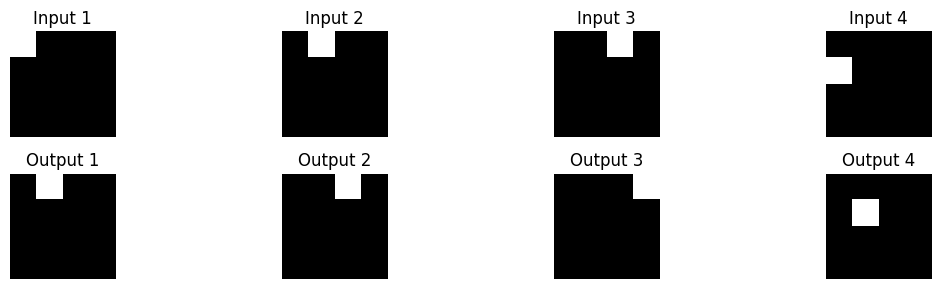

In [2]:
# visualize the dataset
# Create a dataset instance
dataset = ShiftDataset(image_size=IMAGE_SIZE, for_cnn=True)  # Using fewer samples for visualization
print(dataset.inputs.shape)
# Create a figure
plt.figure(figsize=(12, 3))

# Plot a few examples
for i in range(IMAGE_SIZE):
    # Input
    plt.subplot(2, 4, i+1)
    plt.imshow(dataset.inputs[i].squeeze(), cmap='gray')
    plt.title(f'Input {i+1}')
    plt.axis('off')
    
    # Output
    plt.subplot(2, 4, i+5)
    plt.imshow(dataset.outputs[i].squeeze(), cmap='gray')
    plt.title(f'Output {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()


## 2. CNN

### 2.1 Train a 1-layer CNN to shift the white pixel right

In [3]:
# 3. Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = ShiftDataset(image_size=IMAGE_SIZE, for_cnn=True)  # Should output (N, 1, IMAGE_SIZE, IMAGE_SIZE)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

model = SimpleCNN().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)  # Expects (batch, 1, IMAGE_SIZE, IMAGE_SIZE)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_loss = running_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

# 5. Test the Model
model.eval()
with torch.no_grad():
    # Take a sample from the dataset
    test_input, test_target = dataset[0]
    test_input = test_input.unsqueeze(0).to(device)  # Add batch dimension
    test_output = model(test_input)
    
    # Convert to numpy for display
    test_input = test_input.squeeze().cpu().numpy()
    test_output = test_output.squeeze().cpu().numpy()
    test_target = test_target.squeeze().numpy()
    
    print("\nTest Input:")
    print(np.round(test_input, 2))
    print("Model Output:")
    print(np.round(test_output, 2))
    print("Target Output:")
    print(test_target)

# Optional: Save the model
torch.save(model.state_dict(), "shift_cnn.pth")

Epoch [1/100], Loss: 0.3790
Epoch [2/100], Loss: 0.1488
Epoch [3/100], Loss: 0.0801
Epoch [4/100], Loss: 0.0519
Epoch [5/100], Loss: 0.0373
Epoch [6/100], Loss: 0.0291
Epoch [7/100], Loss: 0.0238
Epoch [8/100], Loss: 0.0200
Epoch [9/100], Loss: 0.0171
Epoch [10/100], Loss: 0.0149
Epoch [11/100], Loss: 0.0131
Epoch [12/100], Loss: 0.0117
Epoch [13/100], Loss: 0.0105
Epoch [14/100], Loss: 0.0095
Epoch [15/100], Loss: 0.0086
Epoch [16/100], Loss: 0.0079
Epoch [17/100], Loss: 0.0072
Epoch [18/100], Loss: 0.0067
Epoch [19/100], Loss: 0.0062
Epoch [20/100], Loss: 0.0057
Epoch [21/100], Loss: 0.0053
Epoch [22/100], Loss: 0.0050
Epoch [23/100], Loss: 0.0047
Epoch [24/100], Loss: 0.0044
Epoch [25/100], Loss: 0.0042
Epoch [26/100], Loss: 0.0039
Epoch [27/100], Loss: 0.0037
Epoch [28/100], Loss: 0.0035
Epoch [29/100], Loss: 0.0033
Epoch [30/100], Loss: 0.0032
Epoch [31/100], Loss: 0.0030
Epoch [32/100], Loss: 0.0029
Epoch [33/100], Loss: 0.0028
Epoch [34/100], Loss: 0.0026
Epoch [35/100], Loss: 0

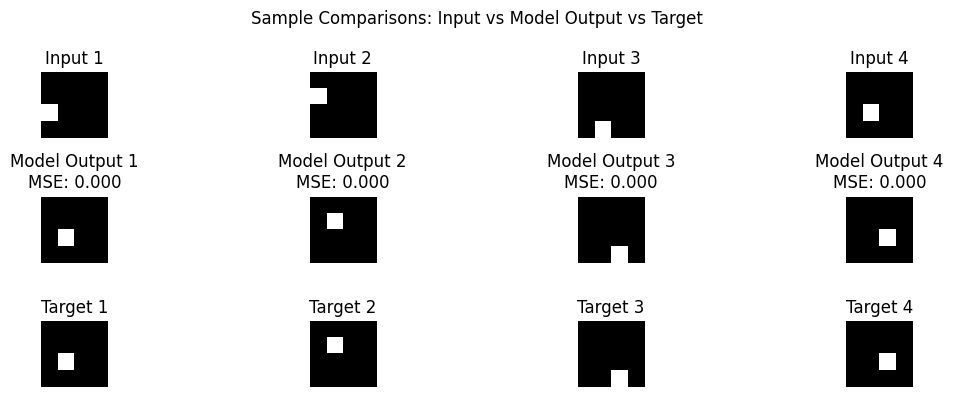

In [4]:
# visualize the model outputs next to the labels
# Create a figure with subplots to compare input, output and target
fig, axes = plt.subplots(3, 4, figsize=(12, 4))
fig.suptitle('Sample Comparisons: Input vs Model Output vs Target')

# Get 4 random samples from dataset
indices = np.random.randint(0, len(dataset), 4)
for i, idx in enumerate(indices):
    input_seq, target = dataset[idx]
    
    # Get model prediction
    model.eval()
    with torch.no_grad():
        input_seq = input_seq.unsqueeze(0).to(device)
        output = model(input_seq)
        
        # Convert tensors to numpy and reshape to 4x4
        input_seq = input_seq.squeeze().cpu().numpy().reshape(IMAGE_SIZE, IMAGE_SIZE)
        output = output.squeeze().cpu().numpy().reshape(IMAGE_SIZE, IMAGE_SIZE)
        target = target.numpy().reshape(IMAGE_SIZE, IMAGE_SIZE)
        
    # Plot input sequence
    axes[0, i].imshow(input_seq, cmap='gray')
    axes[0, i].set_title(f'Input {i+1}')
    axes[0, i].axis('off')
    
    # Plot model output
    axes[1, i].imshow(output, cmap='gray')
    axes[1, i].set_title(f'Model Output {i+1}\nMSE: {np.mean((output-target)**2):.3f}')
    axes[1, i].axis('off')
    
    # Plot target/ground truth
    axes[2, i].imshow(target, cmap='gray')
    axes[2, i].set_title(f'Target {i+1}')
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()

### 2.2 Inspect the CNN

torch.Size([1, 1, 3, 3])


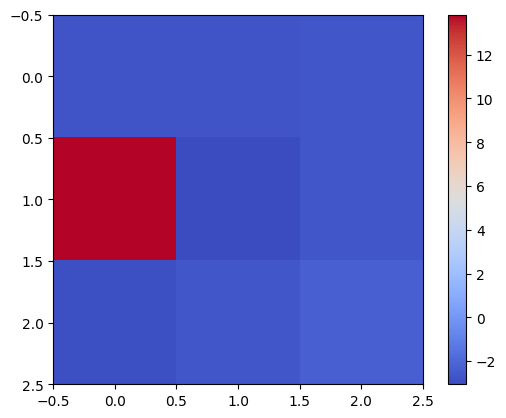

In [5]:
# show me the conv layer kernel, visualize it as an image
print(model.conv.weight.shape)
plt.imshow(model.conv.weight.squeeze().detach().cpu().numpy(), cmap='coolwarm')
plt.colorbar()
plt.show()


makes sense!

## 2. Vision transformer

### 2.1 Train a vision transformer

In [6]:
# config args

# training params

learning_rate = 0.0003
num_epochs = 20000
betas = [0.0001, 0.05]
gamma_ = 0.5
step_size = 10000

# model params
timesteps = 50
embed_dim = 64
num_layers = 1
num_heads = 1

diffusion_trainer = DiffusionTrainer(IMAGE_SIZE, embed_dim, learning_rate, gamma_,
                                      step_size, num_epochs=num_epochs, batch_size=IMAGE_SIZE*(IMAGE_SIZE-1), num_layers=num_layers, num_heads=num_heads, timesteps=timesteps)

In [7]:
model = diffusion_trainer.train()

Number of parameters in the model: 51329
Epoch 0, Loss: 1.2578
Epoch 100, Loss: 0.7708
Epoch 200, Loss: 0.1703
Epoch 300, Loss: 0.1390
Epoch 400, Loss: 0.1749
Epoch 500, Loss: 0.1488
Epoch 600, Loss: 0.2165
Epoch 700, Loss: 0.1098
Epoch 800, Loss: 0.0939
Epoch 900, Loss: 0.2770
Epoch 1000, Loss: 0.0976
Epoch 1100, Loss: 0.0819
Epoch 1200, Loss: 0.1555
Epoch 1300, Loss: 0.1559
Epoch 1400, Loss: 0.1333
Epoch 1500, Loss: 0.0944
Epoch 1600, Loss: 0.0717
Epoch 1700, Loss: 0.0935
Epoch 1800, Loss: 0.1055
Epoch 1900, Loss: 0.0584
Epoch 2000, Loss: 0.0650
Epoch 2100, Loss: 0.0821
Epoch 2200, Loss: 0.1010
Epoch 2300, Loss: 0.1628
Epoch 2400, Loss: 0.0729
Epoch 2500, Loss: 0.0735
Epoch 2600, Loss: 0.1681
Epoch 2700, Loss: 0.1284
Epoch 2800, Loss: 0.1602
Epoch 2900, Loss: 0.0788
Epoch 3000, Loss: 0.0899
Epoch 3100, Loss: 0.0769
Epoch 3200, Loss: 0.0749
Epoch 3300, Loss: 0.1414
Epoch 3400, Loss: 0.1255
Epoch 3500, Loss: 0.1052
Epoch 3600, Loss: 0.0744
Epoch 3700, Loss: 0.0951
Epoch 3800, Loss: 0.1

KeyboardInterrupt: 

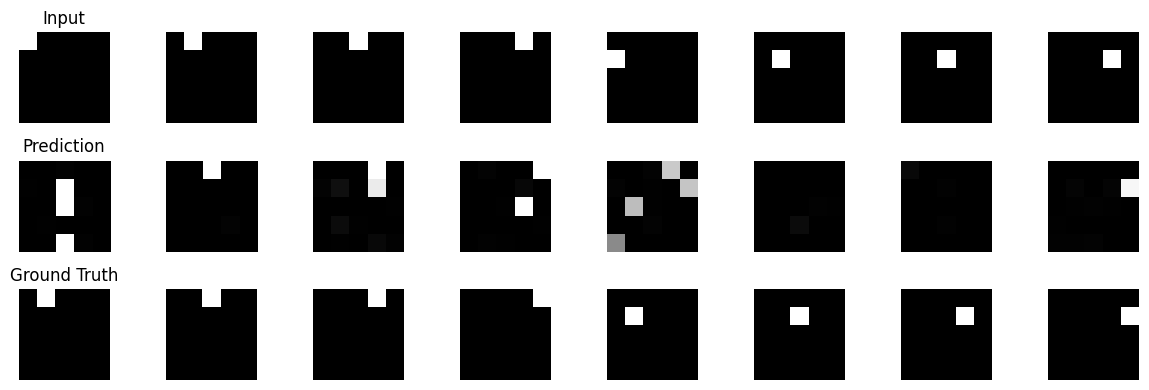

In [ ]:
diffusion_trainer.plot_performance(model)

In [ ]:
mse, f1 = diffusion_trainer.prediction_score(model)
print(mse, ' ', f1)

0.056595672   0.225


### 2.2 Compare vision transformer performance for varying embedding dimensions

In [14]:
# List of embedding dimensions to try
embed_dims = [1, 2, 4, 6, 8, 9, 10, 11, 12, 16]
results = {'embed_dim': [], 'mse': [], 'f1': []}

# Train models for each embedding dimension
for embed_dim in tqdm(embed_dims):
    print(f"\nTraining model with embed_dim={embed_dim}")
    
    # Create trainer with current embed_dim
    diffusion_trainer = DiffusionTrainer(
        image_size=IMAGE_SIZE,
        embed_dim=embed_dim,
        learning_rate=learning_rate,
        gamma_=gamma_,
        step_size=step_size,
        num_epochs=num_epochs,
        batch_size=IMAGE_SIZE*(IMAGE_SIZE-1),
        timesteps=timesteps
    )
    
    # Train model
    model = diffusion_trainer.train(verbose=False)
    
    # Calculate scores
    mse, f1 = diffusion_trainer.prediction_score(model)
    
    # Store results
    results['embed_dim'].append(embed_dim)
    results['mse'].append(mse)
    results['f1'].append(f1)
    
    print(f"MSE: {mse:.4f}, F1: {f1:.4f}")

# Plot results
plt.figure(figsize=(12, 5))

# MSE subplot
plt.subplot(1, 2, 1)
plt.scatter(results['embed_dim'], results['mse'], marker='o')
#plt.xscale('log')
plt.xlabel('Embedding Dimension')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs Embedding Dimension')
plt.grid(True)

# F1 subplot
plt.subplot(1, 2, 2)
plt.scatter(results['embed_dim'], results['f1'], marker='o')
#plt.xscale('log')
plt.xlabel('Embedding Dimension')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Embedding Dimension')
plt.grid(True)

plt.tight_layout()
plt.show()



  0%|          | 0/10 [00:00<?, ?it/s]


Training model with embed_dim=1


TypeError: DiffusionTrainer.__init__() missing 2 required positional arguments: 'num_layers' and 'num_heads'

## 4. Let's look for circuits

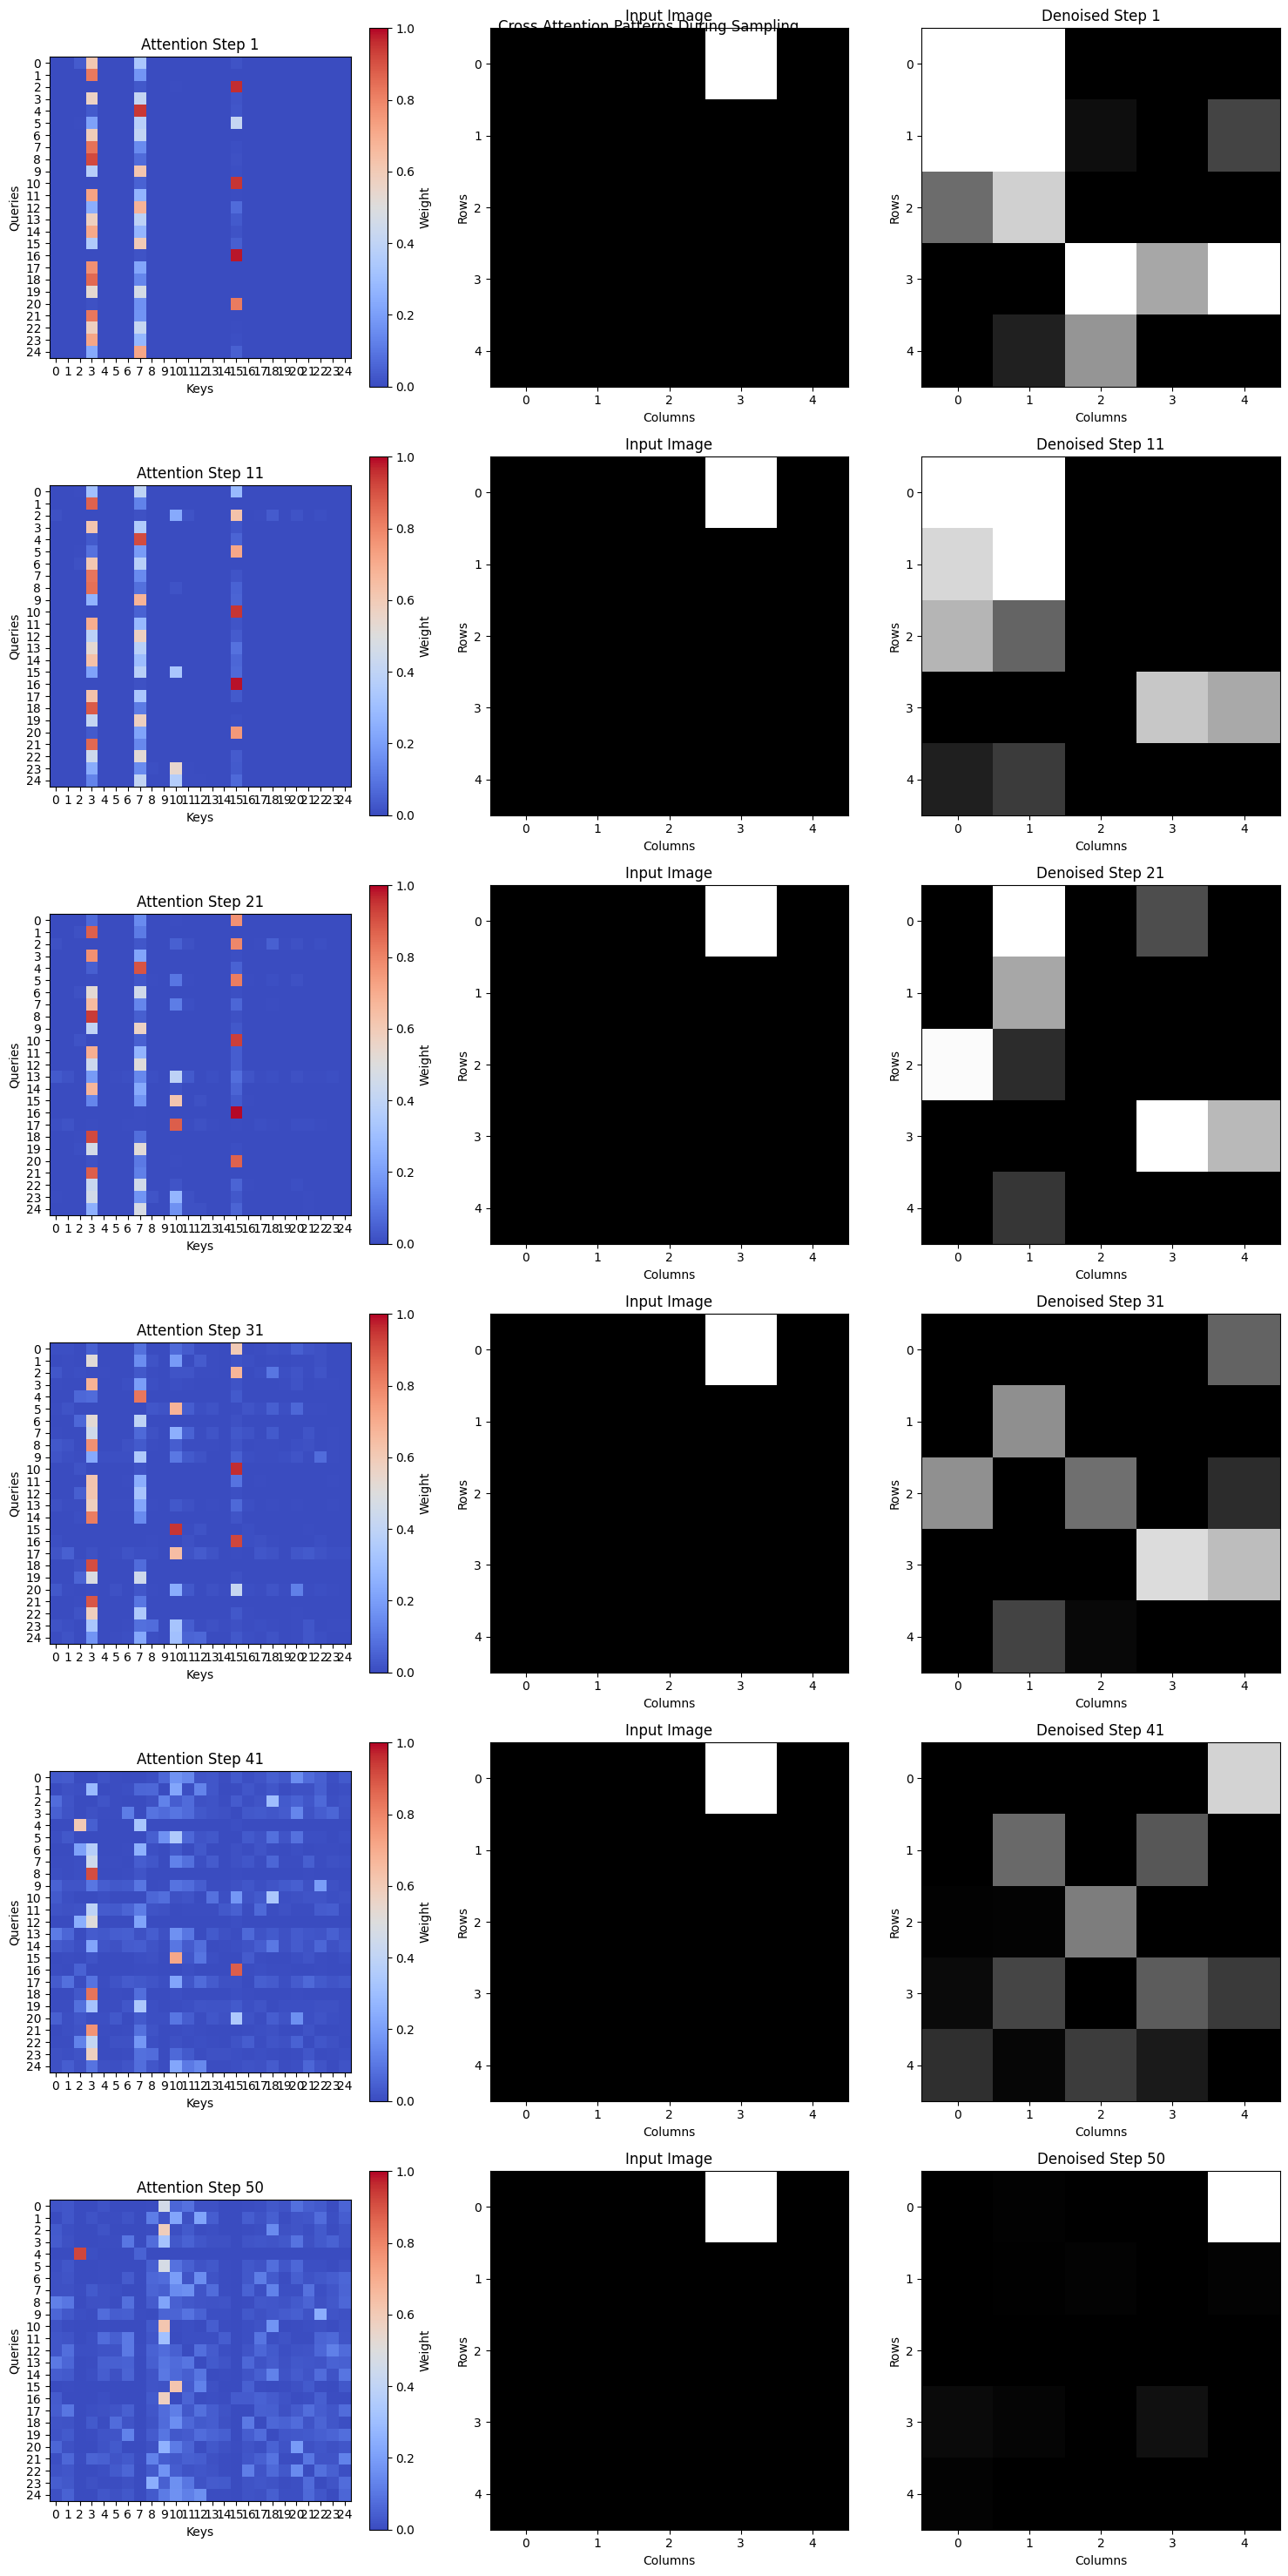

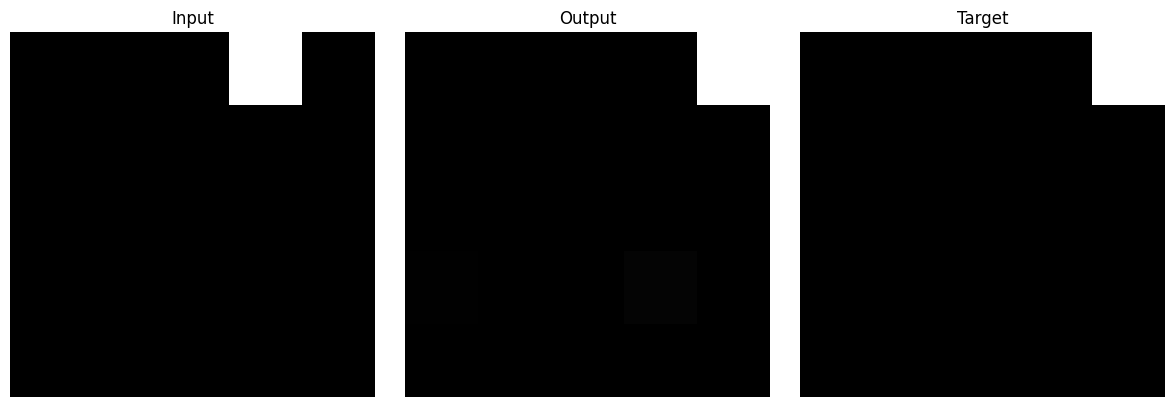

In [33]:
# Get a sample input
x_cond, x_target = diffusion_trainer.dataset[3]
x_cond = x_cond.unsqueeze(0).to(device)


x, x_list, attn_weights_list, poss_white_vecs = model.sample(x_cond, timesteps=timesteps,return_all=True)


# Plot attention patterns vertically
num_steps = len(attn_weights_list)

# Calculate number of rows (every 10th step)
steps_to_plot = [i for i in range(num_steps) if i % 10 == 0 or i == num_steps-1]
num_rows = len(steps_to_plot)

# Create figure with 3 columns (attention, input, denoised) and rows for every 10th step
plt.figure(figsize=(15, 5 * num_rows))  # Width=15, Height=5 per row

for plot_idx, step_idx in enumerate(steps_to_plot):
    # Attention weights
    plt.subplot(num_rows, 3, 3 * plot_idx + 1)
    plt.imshow(attn_weights_list[step_idx], cmap='coolwarm', vmin=0, vmax=1)
    plt.xticks(range(0,IMAGE_SIZE**2))
    plt.yticks(range(0,IMAGE_SIZE**2))
    plt.title(f'Attention Step {step_idx + 1}')
    plt.xlabel('Keys')
    plt.ylabel('Queries')
    plt.colorbar(label='Weight')
    
    #plt.axis('off')  # Optional: remove axis ticks if preferred

    # Input image (x_target, constant across steps)
    plt.subplot(num_rows, 3, 3 * plot_idx + 2)
    plt.imshow(x_cond.numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title(f'Input Image')
    plt.xlabel('Columns')
    plt.ylabel('Rows')
    
    #plt.axis('off')

    # Denoised image (x_list at current step)
    plt.subplot(num_rows, 3, 3 * plot_idx + 3)
    plt.imshow(x_list[step_idx].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray', vmin=0, vmax=1)
    plt.title(f'Denoised Step {step_idx + 1}')
    plt.xlabel('Columns')
    plt.ylabel('Rows')
    
    #plt.axis('off')    

    

plt.suptitle('Cross Attention Patterns During Sampling')
plt.tight_layout()
plt.show()


# Plot final input, output and target
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(x_cond.squeeze().cpu().numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
plt.title('Input')
plt.axis('off')

plt.subplot(132)
plt.imshow(x.squeeze().cpu().numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
plt.title('Output')
plt.axis('off')

plt.subplot(133)
plt.imshow(x_target.numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
plt.title('Target')
plt.axis('off')

plt.tight_layout()
plt.show()


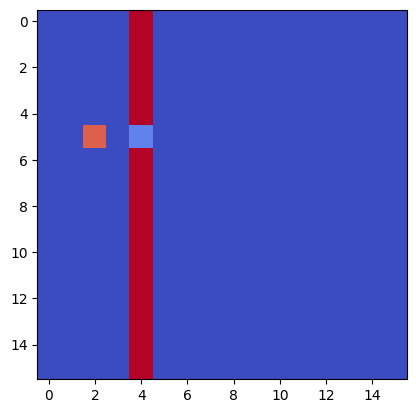

In [17]:
attn_weights_list[0]
plt.imshow(attn_weights_list[0], cmap='coolwarm', vmin=0, vmax=1)


Funky! Let's go through the activations of the model step by step and see what's going on! NB: I generated all the figures and analyzed the activations by checking manually in the debug console, so I have no code saved for this. Sorry about that. As I progress with this project, I will save all the code I write.

In [18]:
model.sample(x_cond, timesteps=timesteps,return_all=True)

(tensor([[9.0998e-04, 0.0000e+00, 1.2231e-02, 0.0000e+00, 1.4405e-04, 1.0000e+00,
          6.2395e-04, 0.0000e+00, 0.0000e+00, 7.1625e-04, 0.0000e+00, 4.6007e-04,
          5.2316e-03, 5.5135e-04, 0.0000e+00, 1.6667e-04]]),
 [tensor([[0.0000, 0.0000, 0.0037, 0.0000, 1.0000, 1.0000, 0.0000, 1.0000, 0.0000,
           0.0000, 0.0000, 0.0877, 0.2320, 0.5670, 0.0000, 0.0000]]),
  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000, 1.0000, 0.0000,
           0.0000, 0.0000, 0.0436, 0.1836, 0.0349, 0.0000, 0.0000]]),
  tensor([[0.0000, 0.0000, 0.0297, 0.0000, 1.0000, 1.0000, 0.0000, 1.0000, 0.0000,
           0.0000, 0.0000, 0.3684, 0.0000, 0.5047, 0.0000, 0.0000]]),
  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000, 1.0000, 0.0000,
           0.0000, 0.0000, 0.1253, 0.0000, 0.4093, 0.0000, 0.0000]]),
  tensor([[0.0000, 0.2165, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000, 1.0000, 0.0000,
           0.0000, 0.0000, 0.3592, 0.0109, 0.5373, 0.0000, 0.0000]]),
  tensor([

### 4.3 Steering vectors

Find the steering vectors

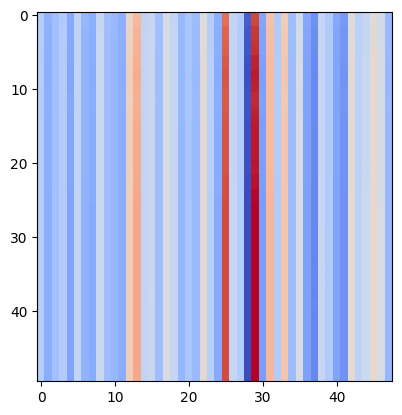

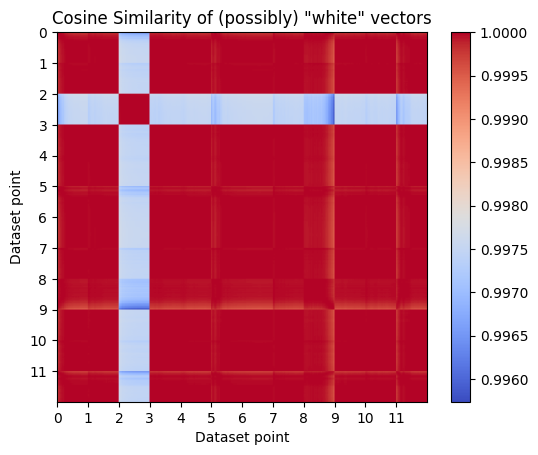

In [7]:

# load model from pth file
model = SteerableDiffusionTransformer(pixel_dim=16, embed_dim=48, num_heads=1, num_layers=1).to(device)
model.load_state_dict(torch.load("models/previous_pixel_model.pth"))

all_poss_white_vecs = []
for x_cond, x_target in diffusion_trainer.dataset:
    x_cond = x_cond.unsqueeze(0).to(device)
    x, x_list, attn_weights_list, poss_white_vecs = model.sample(x_cond, timesteps=timesteps, return_all=True)

    # append all arrays inside poss_white_vecs to the list
    all_poss_white_vecs.extend(poss_white_vecs)

    plt.imshow(poss_white_vecs, cmap='coolwarm')

# calculate the cosine similarity of all_poss_white_vecs with each other

# 1. turn all_poss_white_vecs into a numpy array
all_poss_white_vecs = np.array(all_poss_white_vecs)

# 2. calculate the cosine similarity of all_poss_white_vecs with each other
cosine_similarity = np.dot(all_poss_white_vecs, all_poss_white_vecs.T) / (np.linalg.norm(all_poss_white_vecs, axis=1)[:, np.newaxis] * np.linalg.norm(all_poss_white_vecs, axis=1))

# plot heatmap of cosine similarity
fig, ax = plt.subplots(1, 1)
plt.imshow(cosine_similarity, cmap='coolwarm')
plt.colorbar()
plt.xlabel('Dataset point')
plt.xticks(np.arange(0, len(cosine_similarity), 50))
ax.set_xticklabels(np.arange(0, len(cosine_similarity)//50, 1))

plt.ylabel('Dataset point')
plt.yticks(np.arange(0, len(cosine_similarity), 50))
ax.set_yticklabels(np.arange(0, len(cosine_similarity)//50, 1))

plt.title('Cosine Similarity of (possibly) \"white\" vectors')
plt.show()


Now steer with them

In [1]:
# instantiate a steerable diffusion transformer
steering_vector = all_poss_white_vecs[0]
steering_alpha = -1.
steering_point = 5
steerable_model = SteerableDiffusionTransformer(steering_vector, steering_alpha, steering_point, 
                                                pixel_dim=model.pixel_dim, embed_dim=model.embed_dim, num_heads=model.num_heads, num_layers=model.num_layers).to(device)

# load the weights from the previous model
steerable_model.load_state_dict(model.state_dict())


x_cond, x_target = diffusion_trainer.dataset[0]
x_cond = x_cond.unsqueeze(0).to(device)
x, x_list, attn_weights_list, poss_white_vecs = steerable_model.sample(x_cond, timesteps=timesteps, return_all=True)

# plot the sample
plt.imshow(x.squeeze().cpu().numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray', vmin=0, vmax=1)
plt.title(f'Steering point: {steering_point}')
plt.colorbar()
plt.show()




NameError: name 'all_poss_white_vecs' is not defined

# 5. Now with continuous pixel values!

torch.Size([100, 1, 4, 4])


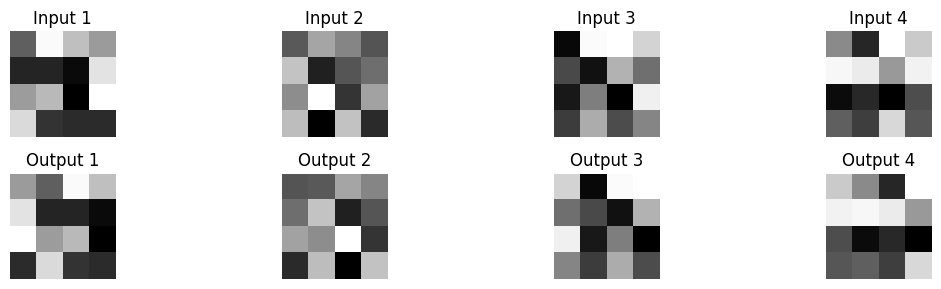

In [13]:
# Test the dataset
dataset = ContinuousShiftDataset(num_samples=100, image_size=IMAGE_SIZE, for_cnn=True)  # Transformer version

print(dataset.inputs.shape)
# Create a figure
plt.figure(figsize=(12, 3))

# Plot a few examples
for i in range(IMAGE_SIZE):
    # Input
    plt.subplot(2, 4, i+1)
    plt.imshow(dataset.inputs[i].squeeze(), cmap='gray')
    plt.title(f'Input {i+1}')
    plt.axis('off')
    
    # Output
    plt.subplot(2, 4, i+5)
    plt.imshow(dataset.outputs[i].squeeze(), cmap='gray')
    plt.title(f'Output {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()


### 5.1 Train a CNN to shift the white pixel right

In [2]:
# 3. Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = ContinuousShiftDataset(num_samples=100, image_size=IMAGE_SIZE, for_cnn=True)  # Should output (N, 1, IMAGE_SIZE, IMAGE_SIZE)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

model = SimpleCNN().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)  # Expects (batch, 1, IMAGE_SIZE, IMAGE_SIZE)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_loss = running_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

# 5. Test the Model
model.eval()
with torch.no_grad():
    # Take a sample from the dataset
    test_input, test_target = dataset[0]
    test_input = test_input.unsqueeze(0).to(device)  # Add batch dimension
    test_output = model(test_input)
    
    # Convert to numpy for display
    test_input = test_input.squeeze().cpu().numpy()
    test_output = test_output.squeeze().cpu().numpy()
    test_target = test_target.squeeze().numpy()
    
    print("\nTest Input:")
    print(np.round(test_input, 2))
    print("Model Output:")
    print(np.round(test_output, 2))
    print("Target Output:")
    print(test_target)

# Optional: Save the model
torch.save(model.state_dict(), "shift_cnn.pth")

/Users/emilryd/video_model_interp/ShiftDataset.py:66: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  self.inputs = torch.tensor(inputs)


Epoch [1/100], Loss: 0.6555
Epoch [2/100], Loss: 0.6178
Epoch [3/100], Loss: 0.6052
Epoch [4/100], Loss: 0.5982
Epoch [5/100], Loss: 0.5961
Epoch [6/100], Loss: 0.5961
Epoch [7/100], Loss: 0.5940
Epoch [8/100], Loss: 0.5941
Epoch [9/100], Loss: 0.5934
Epoch [10/100], Loss: 0.5936
Epoch [11/100], Loss: 0.5934
Epoch [12/100], Loss: 0.5934
Epoch [13/100], Loss: 0.5934
Epoch [14/100], Loss: 0.5936
Epoch [15/100], Loss: 0.5933
Epoch [16/100], Loss: 0.5943
Epoch [17/100], Loss: 0.5945
Epoch [18/100], Loss: 0.5941
Epoch [19/100], Loss: 0.5945
Epoch [20/100], Loss: 0.5941
Epoch [21/100], Loss: 0.5937
Epoch [22/100], Loss: 0.5945
Epoch [23/100], Loss: 0.5937
Epoch [24/100], Loss: 0.5938
Epoch [25/100], Loss: 0.5944
Epoch [26/100], Loss: 0.5942
Epoch [27/100], Loss: 0.5944
Epoch [28/100], Loss: 0.5936
Epoch [29/100], Loss: 0.5942
Epoch [30/100], Loss: 0.5939
Epoch [31/100], Loss: 0.5933
Epoch [32/100], Loss: 0.5936
Epoch [33/100], Loss: 0.5933
Epoch [34/100], Loss: 0.5933
Epoch [35/100], Loss: 0

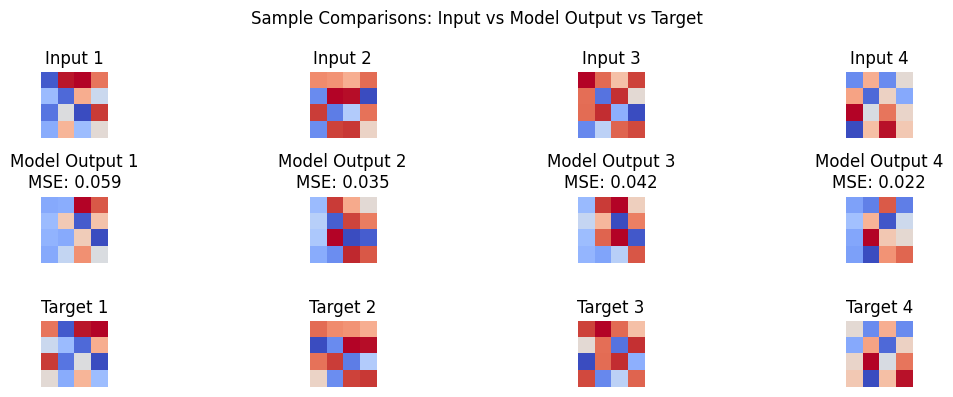

In [3]:
# visualize the model outputs next to the labels
# Create a figure with subplots to compare input, output and target
fig, axes = plt.subplots(3, 4, figsize=(12, 4))
fig.suptitle('Sample Comparisons: Input vs Model Output vs Target')

# Get 4 random samples from dataset
indices = np.random.randint(0, len(dataset), 4)
for i, idx in enumerate(indices):
    input_seq, target = dataset[idx]
    
    # Get model prediction
    model.eval()
    with torch.no_grad():
        input_seq = input_seq.unsqueeze(0).to(device)
        output = model(input_seq)
        
        # Convert tensors to numpy and reshape to 4x4
        input_seq = input_seq.squeeze().cpu().numpy().reshape(IMAGE_SIZE, IMAGE_SIZE)
        output = output.squeeze().cpu().numpy().reshape(IMAGE_SIZE, IMAGE_SIZE)
        target = target.numpy().reshape(IMAGE_SIZE, IMAGE_SIZE)
        
    # Plot input sequence
    axes[0, i].imshow(input_seq, cmap='coolwarm')
    axes[0, i].set_title(f'Input {i+1}')
    axes[0, i].axis('off')
    
    # Plot model output
    axes[1, i].imshow(output, cmap='coolwarm')
    axes[1, i].set_title(f'Model Output {i+1}\nMSE: {np.mean((output-target)**2):.3f}')
    axes[1, i].axis('off')
    
    # Plot target/ground truth
    axes[2, i].imshow(target, cmap='coolwarm')
    axes[2, i].set_title(f'Target {i+1}')
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()









torch.Size([1, 1, 3, 3])


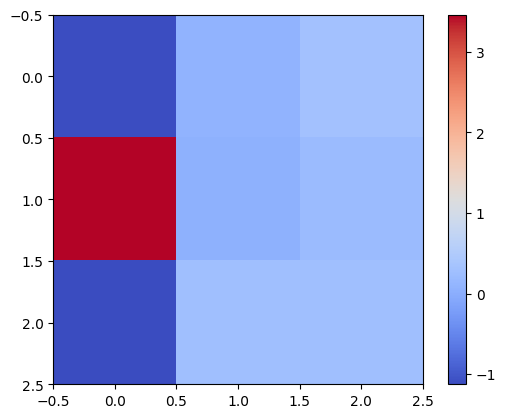

In [4]:
# show me the conv layer kernel, visualize it as an image
print(model.conv.weight.shape)
plt.imshow(model.conv.weight.squeeze().detach().cpu().numpy(), cmap='coolwarm')
plt.colorbar()
plt.show()


Learns everything but how to shift the pixel over from the right end to the left

### 5.2 Train a transformer to shift the white pixel right

In [14]:
# config args

# training params

learning_rate = 0.0005
num_epochs = 1000
betas = [0.0001, 0.05]
gamma_ = 0.5
step_size = 1000
batch_size = 16
num_samples = 100
dataset = ContinuousShiftDataset

# model params
timesteps = 50
embed_dim = 64
num_layers = 1
num_heads = 1

diffusion_trainer = DiffusionTrainer(IMAGE_SIZE, embed_dim, learning_rate, gamma_,
                                      step_size, num_epochs=num_epochs, batch_size=batch_size, num_layers=num_layers, 
                                      num_heads=num_heads, timesteps=timesteps, dataset=dataset, num_samples=num_samples)

In [15]:
model = diffusion_trainer.train()

Number of parameters in the model: 51329
Epoch 0, Loss: 1.0765
Epoch 100, Loss: 0.2814
Epoch 200, Loss: 0.1179
Epoch 300, Loss: 0.0544
Epoch 400, Loss: 0.0615
Epoch 500, Loss: 0.0198
Epoch 600, Loss: 0.0154
Epoch 700, Loss: 0.0231
Epoch 800, Loss: 0.0145
Epoch 900, Loss: 0.0195


Let's see how well it does

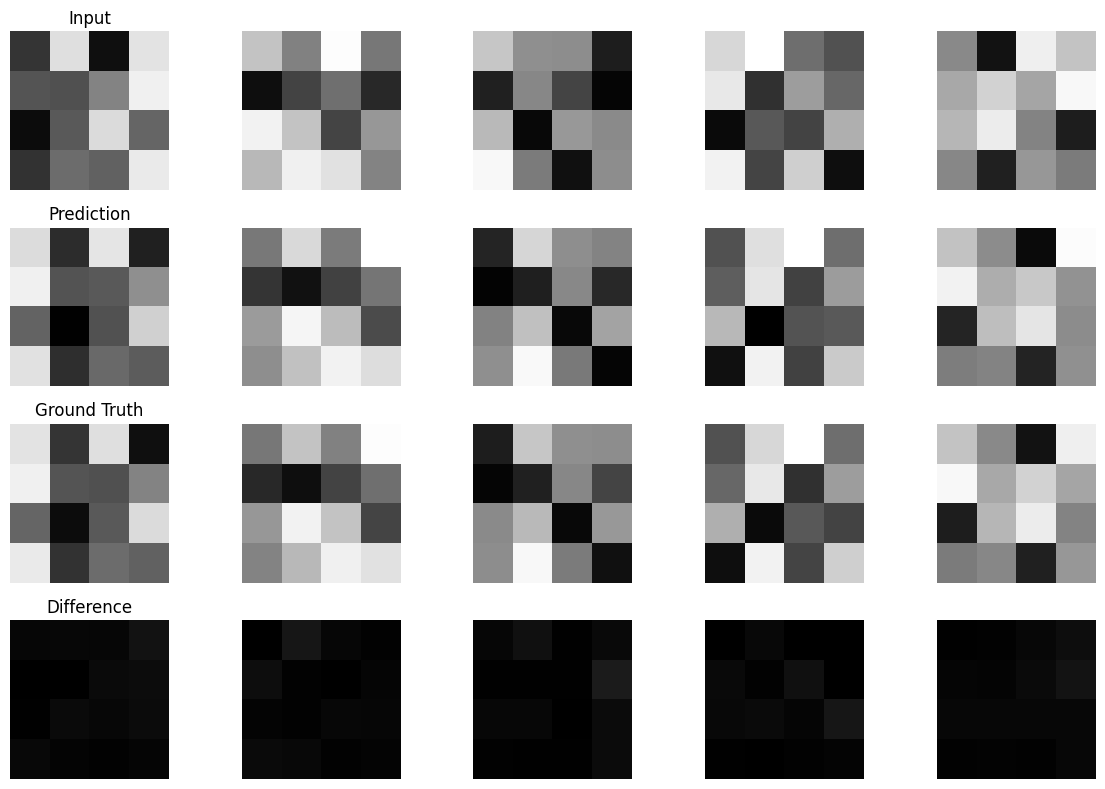

In [16]:
diffusion_trainer.plot_performance(model)

Let's evaluate it quantitatively

In [17]:
mse, f1 = diffusion_trainer.prediction_score(model)
print(mse, ' ', f1)

0.0009796527   0.4163583574141119


0.0010254624   0.4104145377989395


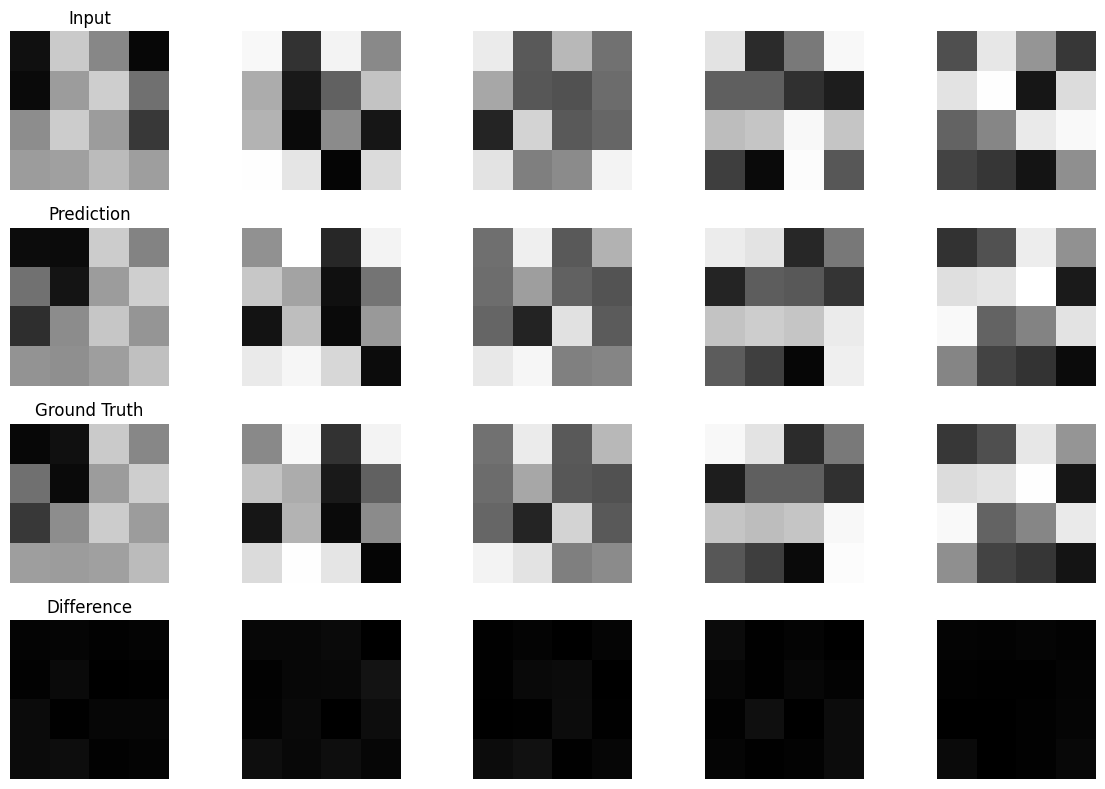

In [22]:
# evaluate on the test set
test_dataset = ContinuousShiftDataset(num_samples=100, image_size=IMAGE_SIZE, for_cnn=False)
diffusion_trainer.dataset = test_dataset
mse, f1 = diffusion_trainer.prediction_score(model)
print(mse, ' ', f1)

diffusion_trainer.plot_performance(model)


### 5.4 Investigate the internals of the transformer

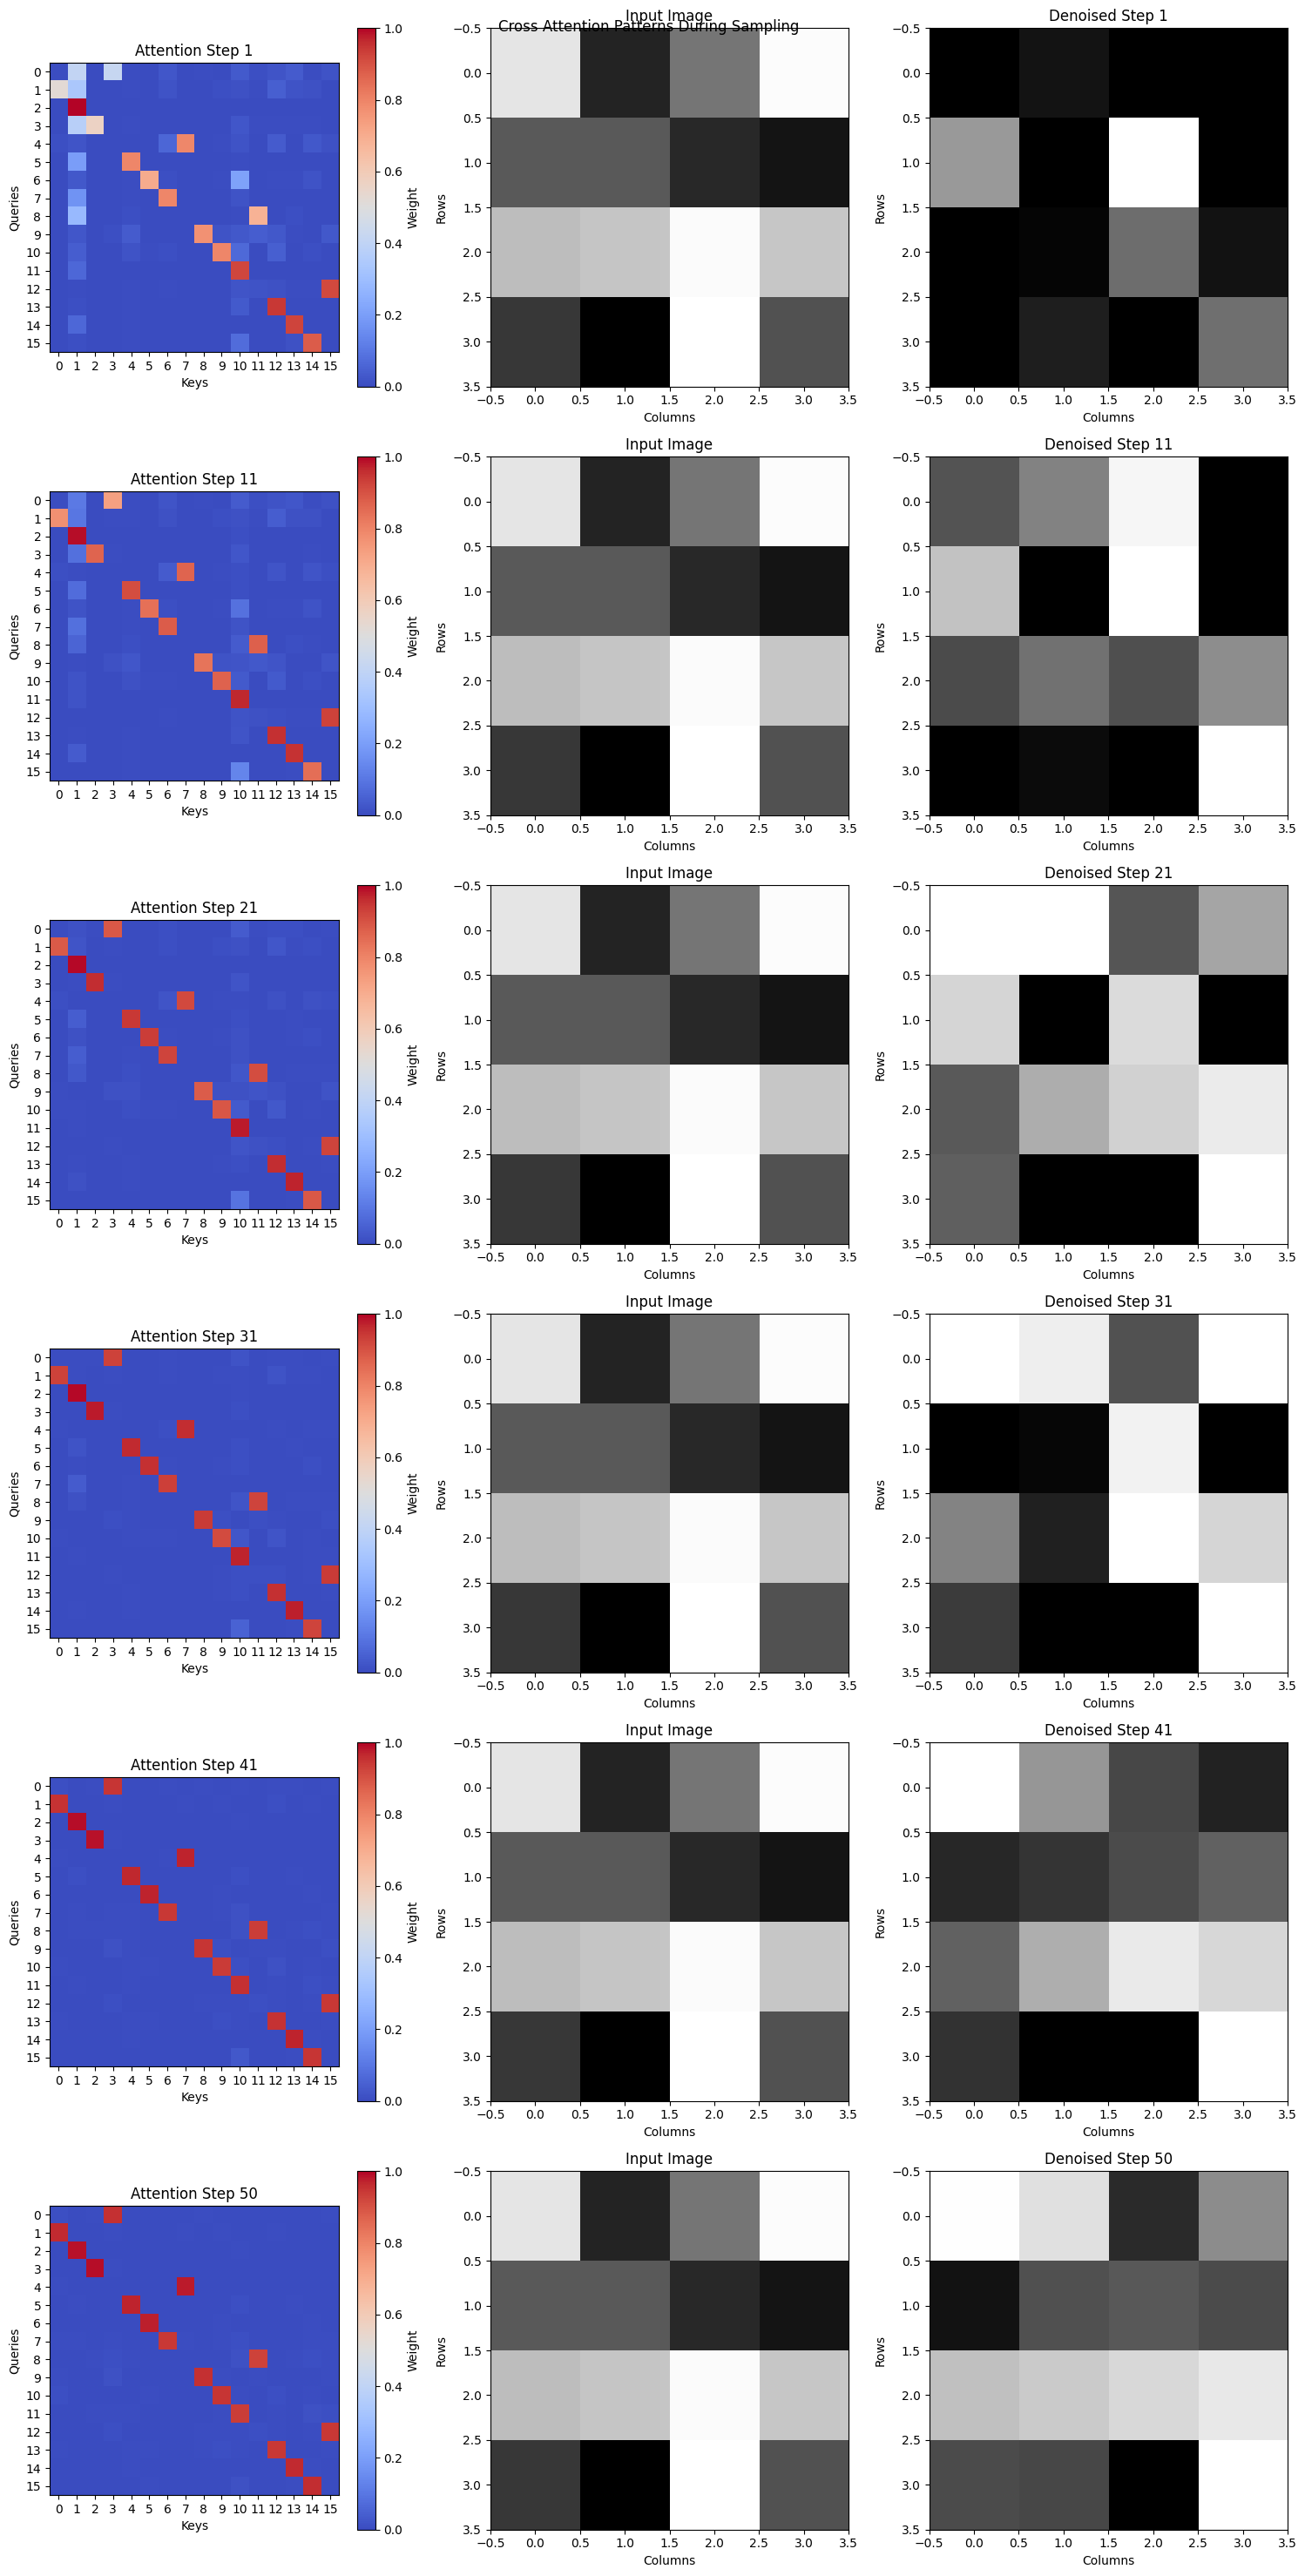

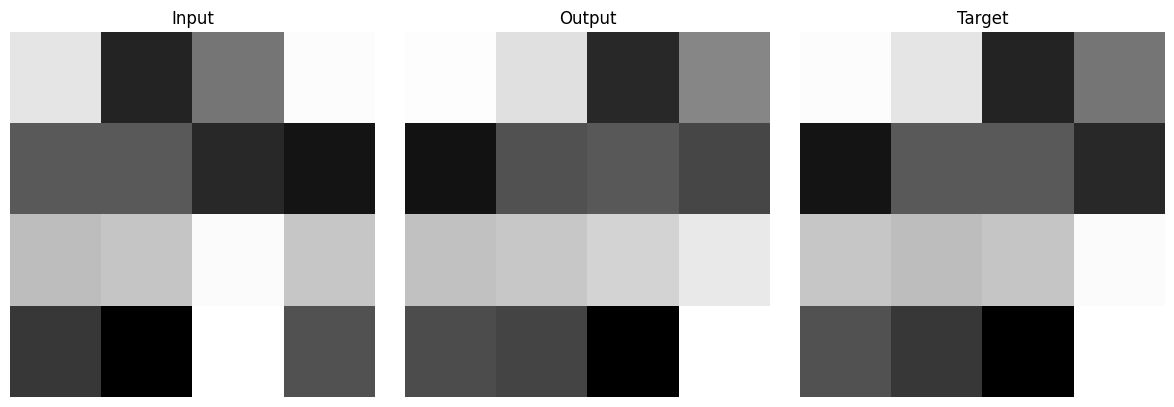

In [24]:
# Get a sample input
x_cond, x_target = diffusion_trainer.dataset[3]
x_cond = x_cond.unsqueeze(0).to(device)


x, x_list, attn_weights_list = model.sample(x_cond, timesteps=timesteps,return_all=True)


# Plot attention patterns vertically
num_steps = len(attn_weights_list)

# Calculate number of rows (every 10th step)
steps_to_plot = [i for i in range(num_steps) if i % 10 == 0 or i == num_steps-1]
num_rows = len(steps_to_plot)

# Create figure with 3 columns (attention, input, denoised) and rows for every 10th step
plt.figure(figsize=(15, 5 * num_rows))  # Width=15, Height=5 per row

for plot_idx, step_idx in enumerate(steps_to_plot):
    # Attention weights
    plt.subplot(num_rows, 3, 3 * plot_idx + 1)
    plt.imshow(attn_weights_list[step_idx], cmap='coolwarm', vmin=0, vmax=1)
    plt.xticks(range(0,IMAGE_SIZE**2))
    plt.yticks(range(0,IMAGE_SIZE**2))
    plt.title(f'Attention Step {step_idx + 1}')
    plt.xlabel('Keys')
    plt.ylabel('Queries')
    plt.colorbar(label='Weight')
    
    #plt.axis('off')  # Optional: remove axis ticks if preferred

    # Input image (x_target, constant across steps)
    plt.subplot(num_rows, 3, 3 * plot_idx + 2)
    plt.imshow(x_cond.numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title(f'Input Image')
    plt.xlabel('Columns')
    plt.ylabel('Rows')
    
    #plt.axis('off')

    # Denoised image (x_list at current step)
    plt.subplot(num_rows, 3, 3 * plot_idx + 3)
    plt.imshow(x_list[step_idx].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray', vmin=0, vmax=1)
    plt.title(f'Denoised Step {step_idx + 1}')
    plt.xlabel('Columns')
    plt.ylabel('Rows')
    
    #plt.axis('off')    

    

plt.suptitle('Cross Attention Patterns During Sampling')
plt.tight_layout()
plt.show()


# Plot final input, output and target
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(x_cond.squeeze().cpu().numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
plt.title('Input')
plt.axis('off')

plt.subplot(132)
plt.imshow(x.squeeze().cpu().numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
plt.title('Output')
plt.axis('off')

plt.subplot(133)
plt.imshow(x_target.numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
plt.title('Target')
plt.axis('off')

plt.tight_layout()
plt.show()
